In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
# Load data
ml_data = pd.read_csv('/content/ML case Study.csv')
college_tiers = pd.read_csv('/content/Colleges.csv')
cities_metro = pd.read_csv('/content/cities.csv')

In [3]:
# Preprocessing steps
def preprocess_data(df, college_tiers, cities_metro):
    # Create college tier mapping
    tier_mapping = {}
    for tier, colleges in {
        'Tier 1': college_tiers['Tier 1'].dropna(),
        'Tier 2': college_tiers['Tier 2'].dropna(),
        'Tier 3': college_tiers['Tier 3'].dropna()
    }.items():
        for college in colleges:
            tier_mapping[college.strip()] = {'Tier 1': 3, 'Tier 2': 2, 'Tier 3': 1}.get(tier, 0)

    # Map college tiers
    df['College_Tier'] = df['College'].map(tier_mapping).fillna(0)

    # Create metro city mapping
    metro_cities = set(cities_metro['Metrio City'].dropna())
    df['Is_Metro'] = df['City'].apply(lambda x: 1 if x in metro_cities else 0)

    # Create Role dummy variables
    df = pd.get_dummies(df, columns=['Role'], prefix='Role')

    return df

In [4]:
# Preprocess the data
processed_data = preprocess_data(ml_data, college_tiers, cities_metro)

# Select features and target
features = [
    'College_Tier', 'Is_Metro', 'Previous CTC',
    'Previous job change', 'Graduation Marks',
    'EXP (Month)', 'Role_Executive', 'Role_Manager'
]
X = processed_data[features]
y = processed_data['CTC']

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Print initial data insights
print("Dataset Shape:", X.shape)
print("\nFeature Correlation with CTC:")
correlation = pd.concat([X, y], axis=1).corr()['CTC'].sort_values(ascending=False)
print(correlation)

Dataset Shape: (1589, 8)

Feature Correlation with CTC:
CTC                    1.000000
Role_Manager           0.621311
EXP (Month)            0.301115
Previous CTC           0.258000
College_Tier           0.029592
Previous job change    0.011370
Graduation Marks      -0.005450
Is_Metro              -0.020365
Role_Executive        -0.621311
Name: CTC, dtype: float64


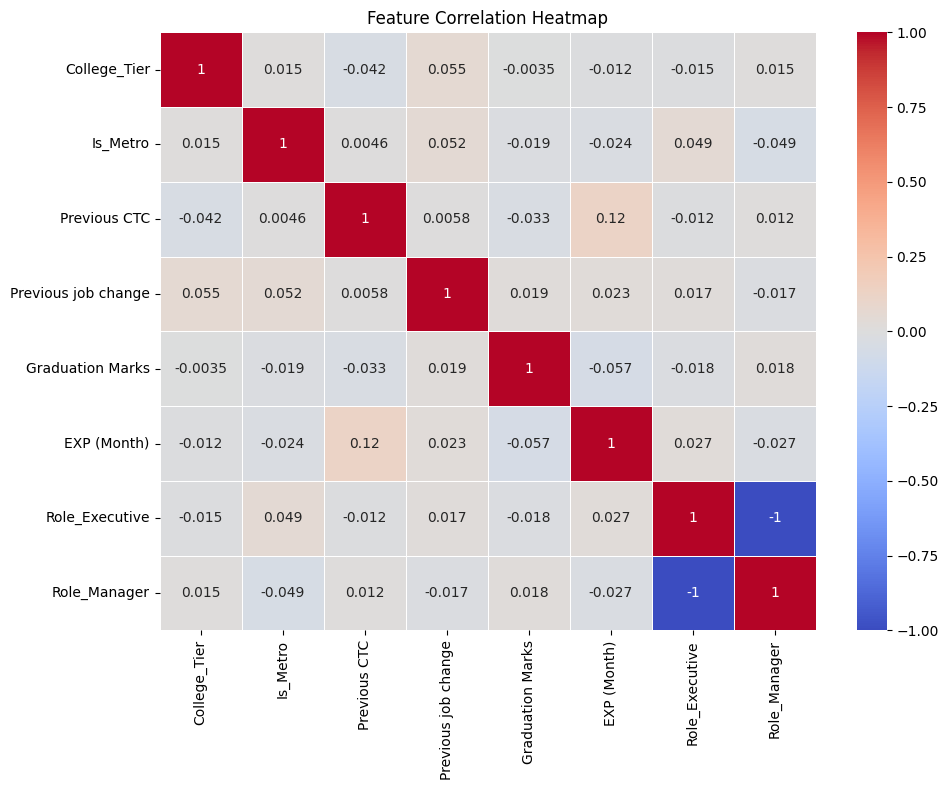

In [7]:
# Visualize feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [17]:
# Detect and handle outliers using IQR method
def detect_outliers(df):
    # Convert boolean columns to numerical (0 or 1) before calculating quantiles
    df_numeric = df.astype(float)  # Convert all columns to float
    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
    return outliers

In [18]:
outliers = detect_outliers(X)
print(f"\nNumber of Outliers Detected: {outliers.sum()}")


Number of Outliers Detected: 332


In [19]:
# Remove outliers
X_clean = X[~outliers]
y_clean = y[~outliers]

# Rescale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

In [20]:
# Model Training Function
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Lasso Regression': Lasso(alpha=0.1),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'Support Vector Regression': SVR(kernel='rbf')
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results[name] = {
            'MSE': mse,
            'R2': r2
        }

    return results

In [21]:
# Evaluate models
model_results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Print results
print("Model Performance Comparison:")
for model, metrics in model_results.items():
    print(f"{model}:")
    print(f"  Mean Squared Error: {metrics['MSE']:.2f}")
    print(f"  R-squared: {metrics['R2']:.4f}\n")

Model Performance Comparison:
Linear Regression:
  Mean Squared Error: 77362774.95
  R-squared: 0.5934

Ridge Regression:
  Mean Squared Error: 77428344.92
  R-squared: 0.5930

Lasso Regression:
  Mean Squared Error: 77363700.20
  R-squared: 0.5933

Random Forest:
  Mean Squared Error: 68273780.86
  R-squared: 0.6411

Gradient Boosting:
  Mean Squared Error: 72825775.52
  R-squared: 0.6172

Support Vector Regression:
  Mean Squared Error: 196768149.71
  R-squared: -0.0343

